In [ ]:
# Install required packages
!pip install transformers[torch]
!pip install -U datasets
!pip install huggingface_hub
!pip install accelerate -U

In [1]:
# Reference: https://huggingface.co/docs/transformers/model_sharing
# make sure that you have a token generated from your HuggingFace account

from huggingface_hub import notebook_login
notebook_login()

In [2]:
from datasets import load_dataset

dataset = load_dataset("sepidmnorozy/Indonesian_sentiment")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
# see the sample
dataset["train"][10]

{'label': 0,
 'text': 'suasana nya asik , romantis , dan ekslusif . pemandangan nya juga sangat bagus . tapi sayang , jalan untuk menuju ke sana nya masih rusak dan jauh .'}

In [4]:
# define the labels

tags = ["NEGATIVE", "POSITIVE"]
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
num_labels = 2

In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

2024-03-20 15:37:47.290029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:37:47.290160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 15:37:47.555220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# model initialization
max_length = 128

def model_init(model_name):
    global tokenizer
    global data_collator
    global tr_model

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=max_length)
    
    return model, tokenizer

In [7]:
# preprocessing

def tokenize_function(examples):
    # process the input sequence
    tokenized_input = tokenizer(examples["text"], 
                                truncation=True, 
                                padding="max_length", 
                                max_length=max_length)
    
    return tokenized_input

def preprocessing():
    tokenized_train_data = dataset["train"].map(tokenize_function, batched=True)
    tokenized_val_data = dataset["validation"].map(tokenize_function, batched=True)
    tokenized_test_data = dataset["test"].map(tokenize_function, batched=True)

    return tokenized_train_data, tokenized_val_data, tokenized_test_data

In [8]:
# define the evaluation metrics

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    
    true_labels = [tags[l] for l in labels] 
    true_predictions = [tags[pr] for pr in pred]

    report = classification_report(true_labels, true_predictions, digits=4)
    acc = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    rec = recall_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    prec = precision_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1 = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro", zero_division=1.0)

    print("Classification Report:\n{}".format(report))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [9]:
# to generate the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

def generate_confusion_matrix(true_labels, pred_labels, num_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    labels = [id2label[i] for i in range(num_labels)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, 
                annot=True, 
                fmt="d", 
                cmap="Blues", 
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.yticks(rotation=0)
    plt.show()

In [10]:
# train the model
import pandas as pd

def train_model(model_name, output_dir, learning_rate, num_epochs):

    model, tokenizer = model_init(model_name)
    train_tokenized, val_tokenized, test_tokenized = preprocessing()
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit = 1,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        load_best_model_at_end=True,
        push_to_hub=True, # to push to hub during the training
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    trainer.save_model(output_dir)
    trainer.push_to_hub(commit_message="Training complete")
    
    # Get the evaluation results
    trainer.eval_dataset=test_tokenized
    evaluation_results = trainer.evaluate()
    print(evaluation_results)
    
    # make prediction on the test set
    predictions = trainer.predict(test_tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = test_tokenized["label"]
    
    # Generate confusion matrix
    generate_confusion_matrix(true_labels, pred_labels, num_labels)
    
    # Show log history
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.fillna(0)
    log_history = log_history.groupby(["epoch"]).sum()
    
    log_history[["loss", "eval_loss"]].plot()
    plt.show()

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/7926 [00:00<?, ? examples/s]

Map:   0%|          | 0/1132 [00:00<?, ? examples/s]

Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.183500,0.103949,0.960247,0.953081,0.962508,0.957393
2,0.063900,0.109426,0.963781,0.958891,0.963151,0.960946
3,0.017600,0.136030,0.965548,0.963370,0.961879,0.962616


Classification Report:
              precision    recall  f1-score   support

    NEGATIVE     0.9233    0.9707    0.9464       409
    POSITIVE     0.9829    0.9544    0.9684       723

    accuracy                         0.9602      1132
   macro avg     0.9531    0.9625    0.9574      1132
weighted avg     0.9614    0.9602    0.9605      1132



/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

    NEGATIVE     0.9402    0.9609    0.9504       409
    POSITIVE     0.9776    0.9654    0.9715       723

    accuracy                         0.9638      1132
   macro avg     0.9589    0.9632    0.9609      1132
weighted avg     0.9641    0.9638    0.9639      1132



/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

    NEGATIVE     0.9557    0.9487    0.9521       409
    POSITIVE     0.9711    0.9751    0.9731       723

    accuracy                         0.9655      1132
   macro avg     0.9634    0.9619    0.9626      1132
weighted avg     0.9655    0.9655    0.9655      1132



events.out.tfevents.1710949088.907f20f46209.115.0:   0%|          | 0.00/7.19k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

    NEGATIVE     0.8977    0.9662    0.9307       799
    POSITIVE     0.9808    0.9400    0.9600      1467

    accuracy                         0.9492      2266
   macro avg     0.9392    0.9531    0.9453      2266
weighted avg     0.9515    0.9492    0.9496      2266

{'eval_loss': 0.1391601711511612, 'eval_accuracy': 0.9492497793468667, 'eval_precision': 0.9392355023321975, 'eval_recall': 0.9531106964823958, 'eval_f1': 0.9453266438775345, 'eval_runtime': 9.8155, 'eval_samples_per_second': 230.86, 'eval_steps_per_second': 3.668, 'epoch': 3.0}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

    NEGATIVE     0.8977    0.9662    0.9307       799
    POSITIVE     0.9808    0.9400    0.9600      1467

    accuracy                         0.9492      2266
   macro avg     0.9392    0.9531    0.9453      2266
weighted avg     0.9515    0.9492    0.9496      2266



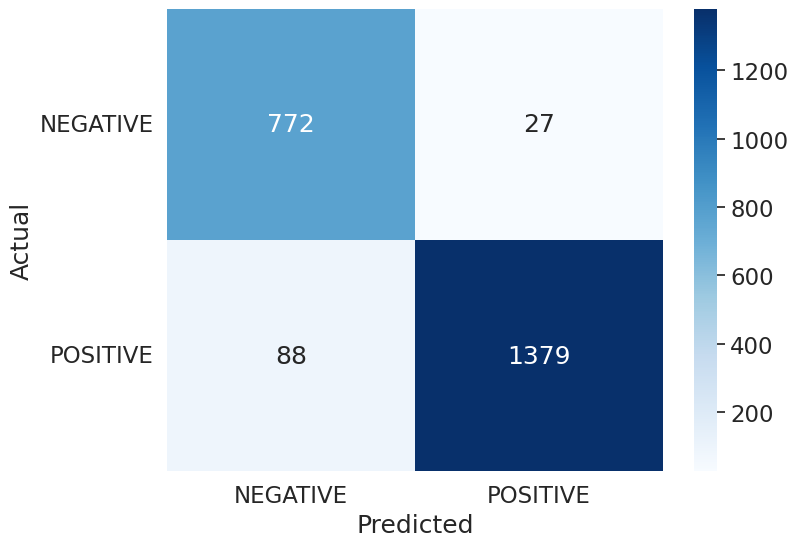

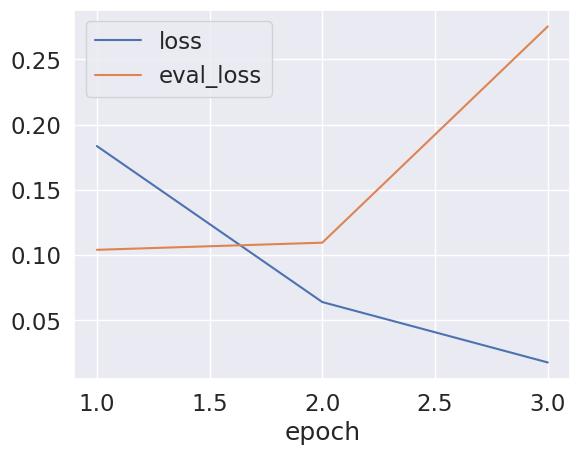

In [11]:
train_model(
    model_name="indolem/indobertweet-base-uncased", 
    output_dir="indo_sentiment_indobertweet", 
    learning_rate=0.0001, 
    num_epochs=3
)